# 6. Análisis predictivo con Naive Bayes

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
import warnings

# Ignorar avisos específicos
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
#Cargamos el dataset nuestro 
ruta_fichero = 'C:/Users/alvar/Documentos/Europea/Europea/3º INFORMÁTICA/IA/PRÁCTICA NAVIDAD/dataset_modificado_sin_prec.csv'
fichero = pd.read_csv(ruta_fichero)

In [3]:
X = fichero.drop('lluvia', axis=1)  # Features
y = fichero['lluvia']  # Variable de salida

# División en 80/20 para entrenamiento y val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear conjuntos de entrenamiento y prueba
conjunto_train = pd.concat([X_train, y_train], axis=1)
conjunto_val = pd.concat([X_val, y_val], axis=1)


# Creamos dos conjuntos para poner las predicciones del train y test
conjunto_train_eval = conjunto_train.copy()
conjunto_validation_eval = conjunto_val.copy()

# Imprimir tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de validación:", len(X_val))

Tamaño del conjunto de entrenamiento: 6076
Tamaño del conjunto de validación: 1520


In [4]:
precision_train = {}
precision_val = {}

In [5]:
# Método de control (k-fold cross-validation)
metodo_control_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Crear un pipeline con escalado y clasificador Naive Bayes
nb_pipeline = make_pipeline(StandardScaler(), GaussianNB())

# Definir los parámetros que deseas ajustar
nb_params = {}  # No hay hiperparámetros específicos para ajustar en GaussianNB

In [6]:
# Entrenar el modelo con GridSearchCV para ajustar los hiperparámetros
nb_grid = GridSearchCV(nb_pipeline, nb_params, scoring='accuracy', cv=metodo_control_cv)
nb_grid.fit(X_train, y_train)

# Obtener el mejor modelo
best_nb_model = nb_grid.best_estimator_

In [7]:
# Realizar predicciones con validación cruzada
y_pred_cv = cross_val_predict(best_nb_model, X_train, y_train, cv=metodo_control_cv)

# Calcular la precisión con validación cruzada
accuracy_cv = accuracy_score(y_train, y_pred_cv)

print(f"Precisión con validación cruzada: {accuracy_cv:.2%}")

Precisión con validación cruzada: 74.59%


In [8]:
# Matriz de confusión con validación cruzada
conf_matrix_cv = confusion_matrix(y_train, y_pred_cv)

In [9]:
print(conf_matrix_cv)

[[2969  637]
 [ 907 1563]]


#### Como nuestro modelo fue entrenado con todas las características del conjunto de datos, para usar solo dos en la visualización, necesitararemos crear un conjunto de datos completo que incluya valores fijos (por ejemplo, el promedio) para las otras características.

C:\Users\alvar\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


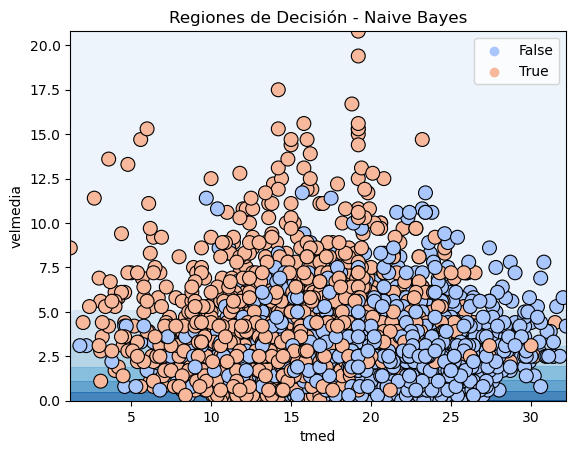

In [10]:
# Obtener el mejor modelo de GridSearchCV
best_nb_model = nb_grid.best_estimator_

# Entrenar el modelo con los datos de entrenamiento
best_nb_model.fit(X_train, y_train)

# Crear un meshgrid para visualizar las regiones de decisión
xx, yy = np.meshgrid(np.linspace(X_train['tmed'].min(), X_train['tmed'].max(), 100),
                     np.linspace(X_train['velmedia'].min(), X_train['velmedia'].max(), 100))

average_values = X_train.mean()
full_data = np.c_[xx.ravel(), yy.ravel()]

for feature in X_train.columns:
    if feature not in ['tmed', 'velmedia']:
        full_data = np.c_[full_data, np.full(full_data.shape[0], average_values[feature])]

# Obtener las probabilidades predichas para cada punto en el meshgrid
Z = best_nb_model.predict_proba(full_data)[:, 1]
Z = Z.reshape(xx.shape)

# Graficar el contorno con las regiones coloreadas según las probabilidades
plt.contourf(xx, yy, Z, cmap='Blues', alpha=0.8)

# Graficar los puntos de entrenamiento
sns.scatterplot(x='tmed', y='velmedia', hue=y_train, data=X_train, palette='coolwarm', edgecolor='k', s=100)

# Etiquetas y título
plt.title('Regiones de Decisión - Naive Bayes')
plt.xlabel('tmed')
plt.ylabel('velmedia')
plt.legend()
plt.show()

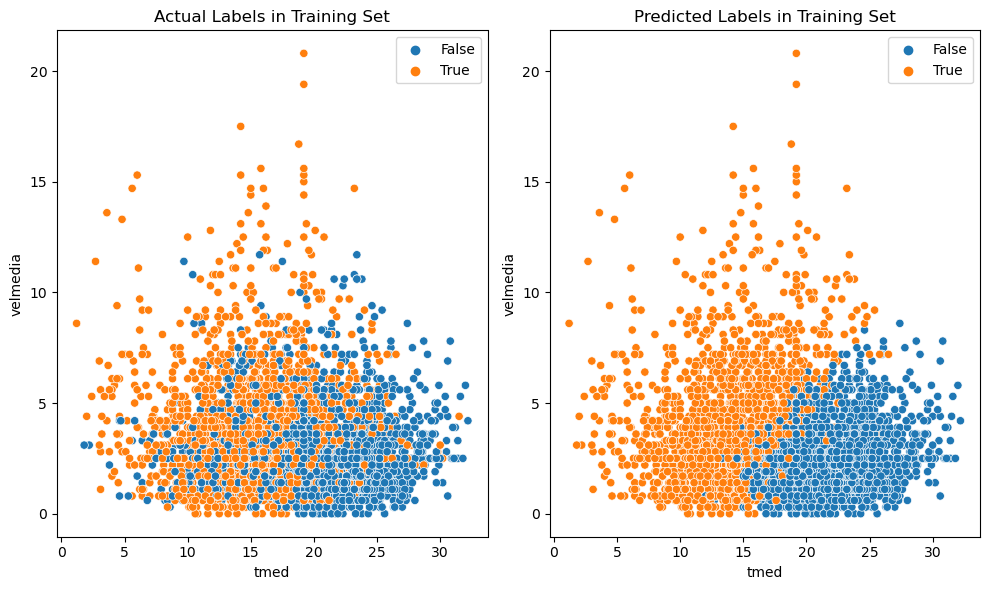

In [14]:
# Asegúrate de que best_nb_model ya está definido y entrenado.

# Predecir las etiquetas para el conjunto de entrenamiento
y_pred_train = best_nb_model.predict(X_train)

# Ahora y_pred_train está definida y puedes usarla para la visualización
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='tmed', y='velmedia', hue=y_train, data=X_train)
plt.title('Actual Labels in Training Set')
plt.xlabel('tmed')
plt.ylabel('velmedia')
plt.legend()

plt.subplot(1, 2, 2)
sns.scatterplot(x='tmed', y='velmedia', hue=y_pred_train, data=X_train)
plt.title('Predicted Labels in Training Set')
plt.xlabel('tmed')
plt.ylabel('velmedia')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Predecir las etiquetas para el conjunto de validación
y_pred_val = best_nb_model.predict(X_val)

# Calcular la matriz de confusión
conf_matrix_val = confusion_matrix(y_val, y_pred_val)
print("Matriz de Confusión en el conjunto de validación:")
print(conf_matrix_val)

# Calcular y mostrar la precisión en el conjunto de validación
precision_val = accuracy_score(y_val, y_pred_val)
print(f"Precisión en el conjunto de validación: {precision_val:.2%}")

Matriz de Confusión en el conjunto de validación:
[[737 169]
 [221 393]]
Precisión en el conjunto de validación: 74.34%


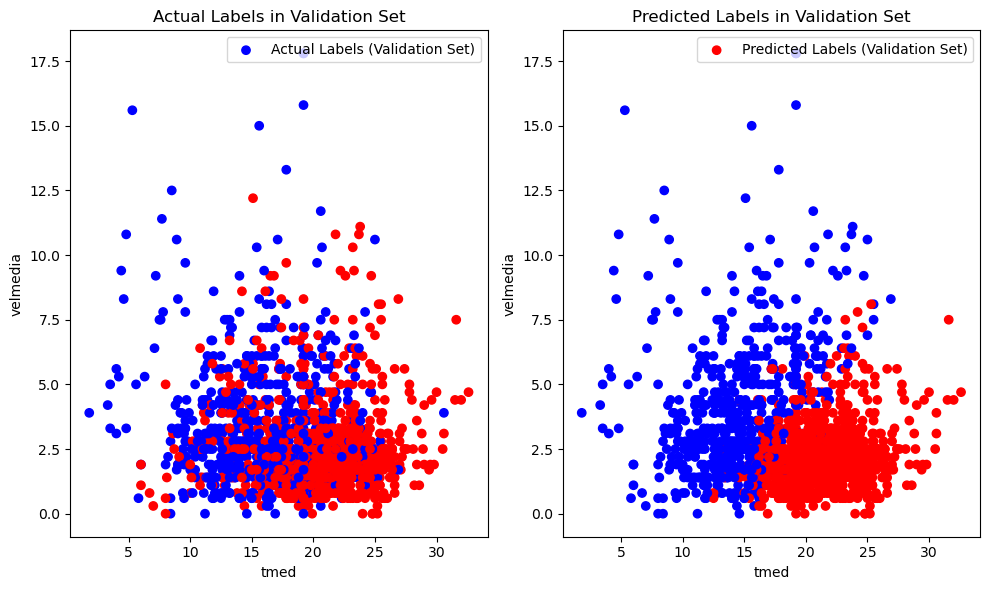

In [16]:
# Predecir las etiquetas para el conjunto de validación
y_pred_val = best_nb_model.predict(X_val)

# Crear un DataFrame con las características y las etiquetas reales y predichas en el conjunto de validación
df_val_predictions = X_val.copy()
df_val_predictions['Actual Label'] = y_val
df_val_predictions['Predicted Label'] = y_pred_val

# Graficar los valores reales y predichos en el conjunto de validación
plt.figure(figsize=(10, 6))

# Asegúrate de que 'tmed' y 'velmedia' son los nombres correctos de tus características
plt.subplot(1, 2, 1)
plt.scatter(X_val['tmed'], X_val['velmedia'], c=y_val.map({False: 'red', True: 'blue'}), label='Actual Labels (Validation Set)')
plt.title('Actual Labels in Validation Set')
plt.xlabel('tmed')
plt.ylabel('velmedia')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(df_val_predictions['tmed'], df_val_predictions['velmedia'], c=df_val_predictions['Predicted Label'].map({False: 'red', True: 'blue'}), label='Predicted Labels (Validation Set)')
plt.title('Predicted Labels in Validation Set')
plt.xlabel('tmed')
plt.ylabel('velmedia')
plt.legend()

plt.tight_layout()
plt.show()


# Conclusiones Finales

## Consistencia en la Precisión

La precisión del modelo es bastante consistente entre la validación cruzada en el conjunto de entrenamiento (74.59%) y la precisión en el conjunto de validación (74.34%). Esto sugiere que el modelo tiene un rendimiento estable y no parece sufrir de sobreajuste significativo, ya que la precisión no cae drásticamente cuando se aplica a datos no vistos durante el entrenamiento.

## Análisis matriz de confusión - Entrenamiento

- Verdaderos Positivos (VP): 1563 son verdaderos positivos.
- Verdaderos Negativos (VN): 2969 son verdaderos negativos.
- Falsos Positivos (FP): 637 falsos positivos.
- Falsos Negativos (FN): 907 falsos negativos.

## Análisis matriz de confusión - Validación

- Verdaderos Positivos (VP): 393 verdaderos positivos.
- Verdaderos Negativos (VN): 737 verdaderos negativos.
- Falsos Positivos (FP): Había 637 falsos positivos en el conjunto de entrenamiento y 169 en el de validación. Estos son casos en los que el modelo predijo incorrectamente la clase positiva.
- Falsos Negativos (FN): El modelo ha hecho 907 falsos negativos en el conjunto de entrenamiento y 221 en el de validación, donde se predijo incorrectamente la clase negativa.